# SPA J=0 to J=1 with RC background

# Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import psutil
from astropy import units
from joblib import Parallel, delayed
import numpy.typing as npt
from scipy import signal, stats
import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

from centrex_tlf import couplings, states, utils
from centrex_tlf.states import ElectronicState, UncoupledBasisState, UncoupledState
from state_prep.electric_fields import ElectricField, Ez_from_csv
from state_prep.hamiltonians import SlowHamiltonian
from state_prep.intensity_profiles import BackgroundField, GaussianBeam
from state_prep.magnetic_fields import MagneticField
from state_prep.microwaves import MicrowaveField, Polarization
from state_prep.simulator import Simulator
from state_prep.trajectory import Trajectory
from state_prep.utils import (
    calculate_transition_frequency,
    find_max_overlap_idx,
    find_closest_vector_idx,
    vector_to_state,
)


In [2]:
plt.rcParams.update({"font.size": 14})

In [3]:
cwd = Path().cwd().absolute()
path_data = cwd / "results"


In [4]:
nr_cores = psutil.cpu_count(logical=False) + 2

rng = np.random.default_rng()


# Setup

## Define molecule trajectory
Defining the molecule trajectory as a Trajectory object. Specifying the initial position as z = 50 mm, i.e. 50mm  after the center of the microwaves is, and on the axis of the beamline. Taking the beam velocity to be 200 m/s in the z-direction. The simulation ends when `zfin` is reached, 200 mm from the microwwaves.

In [5]:
trajectory = Trajectory(
    Rini=np.array((0, 0, -80e-3)), Vini=np.array((0, 0, 200.0)), zfin=200e-3
)

## Define electric field
Defining an electric field that is an approximation of what the molecules should see in the real experiment.

In [6]:
# Define electric field based on finite element simulations
Ez = Ez_from_csv()
E_R = lambda R: np.array([0, 0, Ez(R[2])])


electric_field = ElectricField(E_R, trajectory.R_t)

Max electric field: 263.46 V/cm
Electric field at z = 0: 172.39 V/cm
Electric field at z = 1.125'': 109.24 V/cm


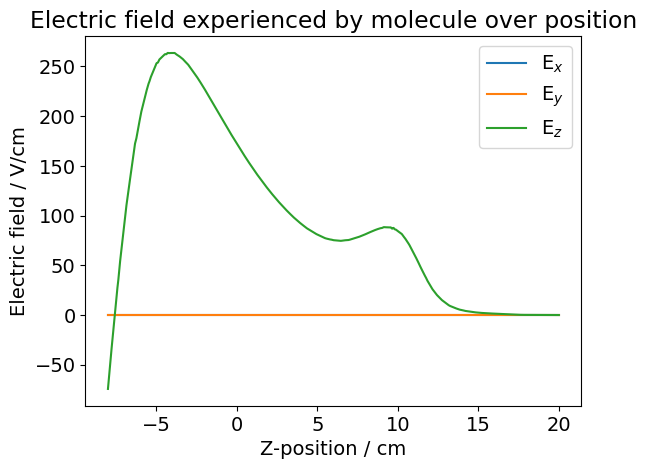

In [7]:
# Plot the electric field as a check:
ts, Es, ax = electric_field.plot(trajectory, position=True)

print(f"Max electric field: {np.max(Es):.2f} V/cm")
print(f"Electric field at z = 0: {E_R(np.array([0, 0, 0]))[2]:.2f} V/cm")
print(
    f"Electric field at z = 1.125'': {E_R(np.array([0, 0, 0.0254 * 1.125]))[2]:.2f} V/cm"
)

## Define magnetic field
Define the magnetic field. Using a constant field, either a nominal small field (so mF states become non-degenerate eigenstates of the Hamiltonian) or something resembilng Earth's magnetic field.

In [8]:
B = np.array((0, 0, 1e-3))


# B = np.array((0.2,0.45,0.1))
def B_R(R):
    if len(R.shape) == 1:
        return B
    else:
        return B.reshape((3, 1)) * np.ones(R.shape)


magnetic_field = MagneticField(B_R, R_t=trajectory.R_t)

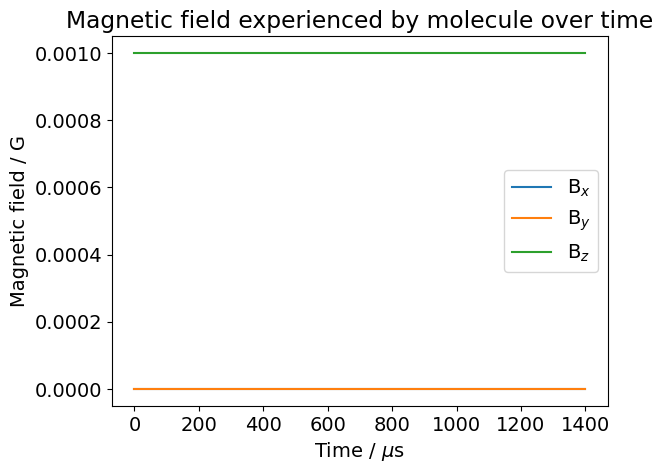

In [9]:
magnetic_field.plot(trajectory)

## Initial and final states
Define approximate initial states here.

In [10]:
# Define some useful approximate states
J0_singlet = (
    1
    / np.sqrt(2)
    * (
        1
        * UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=+1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
        - 1
        * UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=+1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
    )
)

J0_triplet_0 = (
    1
    / np.sqrt(2)
    * (
        1
        * UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=+1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
        + 1
        * UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=+1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
    )
)

J0_triplet_p = 1 * UncoupledBasisState(
    J=0,
    mJ=0,
    I1=1 / 2,
    m1=1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=+1,
    Omega=0,
    electronic_state=ElectronicState.X,
)

J0_triplet_m = 1 * UncoupledBasisState(
    J=0,
    mJ=0,
    I1=1 / 2,
    m1=-1 / 2,
    I2=1 / 2,
    m2=-1 / 2,
    P=+1,
    Omega=0,
    electronic_state=ElectronicState.X,
)

initial_states_approx = [J0_singlet, J0_triplet_m, J0_triplet_0, J0_triplet_p]

In [11]:
# Define some useful approximate states
J1_singlet = (
    1
    / np.sqrt(2)
    * (
        1
        * UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=-1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
        - 1
        * UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=-1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
    )
)

J1_triplet_0 = (
    1
    / np.sqrt(2)
    * (
        1
        * UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=-1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
        + 1
        * UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=-1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
    )
)

J1_triplet_p = 1 * UncoupledBasisState(
    J=1,
    mJ=0,
    I1=1 / 2,
    m1=1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=-1,
    Omega=0,
    electronic_state=ElectronicState.X,
)

J1_triplet_m = 1 * UncoupledBasisState(
    J=1,
    mJ=0,
    I1=1 / 2,
    m1=-1 / 2,
    I2=1 / 2,
    m2=-1 / 2,
    P=-1,
    Omega=0,
    electronic_state=ElectronicState.X,
)

# initial_states_approx = [J1_singlet, J1_triplet_m, J1_triplet_0, J1_triplet_p]

In [12]:
J2_singlet = (
    1
    / np.sqrt(2)
    * (
        1
        * states.UncoupledBasisState(
            J=2,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
        - 1
        * states.UncoupledBasisState(
            J=2,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
    )
)

J2_triplet_0 = (
    1
    / np.sqrt(2)
    * (
        1
        * states.UncoupledBasisState(
            J=2,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
        + 1
        * states.UncoupledBasisState(
            J=2,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
    )
)

J2_triplet_p = 1 * states.UncoupledBasisState(
    J=2,
    mJ=0,
    I1=1 / 2,
    m1=1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

J2_triplet_m = 1 * states.UncoupledBasisState(
    J=2,
    mJ=0,
    I1=1 / 2,
    m1=-1 / 2,
    I2=1 / 2,
    m2=-1 / 2,
    P=1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

# final_states_approx = [J2_singlet, J2_triplet_m, J2_triplet_0, J2_triplet_p]


## Define slowly varying Hamiltonian
Define a Hamiltonian object that represents the slowly varying part of the Hamiltonian (i.e. everything except the microwaves). Using J = 0-3 here since we're interested in the time-evolution of J = 0 and 1 states; J = 0 and 3 are absolutely required since the electric field couples J = 0 to these, J = 3 is not strictly necessary. Since the Stark energies are << the rotational energies, we mostly just need the J of interest $\pm 1$.

In [13]:
Js = [0, 1, 2, 3]
hamiltonian = SlowHamiltonian(Js, trajectory, electric_field, magnetic_field)

## Define microwave Hamiltonian
We will define a microwave field with the following properties
- A Gaussian spatial profile with 1'' intensity FWHM (cylindrically symmetric) 
- propagating along the X-direction
- polarized along the Z-direction
- Calculate power based on the desired Rabi rate for the desired transition

### J=0 to J=1

In [14]:
# Define states
state1 = J0_triplet_0
state2 = J1_triplet_0

# Center position
R0 = np.array((0.00, 0, -0.0))

#### Polarization:
# Define polarization components
p_x = np.array([1, 0, 0])
p_y = np.array([0, 1, 0])
p_z = np.array([0, 0, 1])

# Define a function that gives the main component of the polarization as a function of position
p_main = p_z
P_R = lambda R: p_main / np.sqrt(np.sum(p_main**2))

# Define k-vector
k = np.array((1, 0, 0))
pol = Polarization(P_R, k, f_long=1)

#### Frequency
# Calculate the microwave frequency between specified states at a specific point
detuning_1 = 0e6
muW_freq_1 = (
    calculate_transition_frequency(state1, state2, hamiltonian.H_R(R0), hamiltonian.QN)
    + detuning_1
)
print(f"Transition frequency at center of SPA1 microwaves: {muW_freq_1 / 1e9:.5f} GHz")

#### Intensity profile:
# Define a Gaussian intensity profile
# intensity = MeasuredBeam(power = 1e-3, sigma = 1*25.4e-3/(2*np.sqrt(2*np.log(2))), R0 = R0, k = k, freq = muW_freq)
intensity = GaussianBeam(
    power=0.5e-3,
    sigma=1 * 25.4e-3 / (2 * np.sqrt(2 * np.log(2))),
    R0=R0,
    k=k,
    freq=muW_freq_1,
)

#### Define MicrowaveField
mf01 = MicrowaveField(0, 1, intensity, pol, muW_freq_1, hamiltonian.QN)

Transition frequency at center of SPA1 microwaves: 13.34005 GHz


### RC background field

In [29]:
muW_rc_freq = calculate_transition_frequency(
    J1_singlet,
    J2_singlet,
    hamiltonian.H_R(np.array([0.0, 0.0, -25e-2])),
    hamiltonian.QN,
)
print(f"Transition frequency at 0 V/cm: {muW_rc_freq / 1e9:.5f} GHz")


Transition frequency at 0 V/cm: 26.66937 GHz


In [40]:
# Define a function that gives the main component of the polarization as a function of position
p_rc = p_z + 0.4 * p_y
P_R_RC = lambda R: p_rc / np.sqrt(np.sum(p_rc**2))

# Define k-vector
k = np.array((1, 0, 0))
pol = Polarization(P_R_RC, k, f_long=1)


pol_bg_rc = Polarization(P_R_RC)
# Define a Gaussian intensity profile
lims = [
    (-1, 1),
    (-1, 1),
    (-1, 1),
]
intensity_bg_rc = BackgroundField(lims, intensity=mf01.intensity.I_R(R0) / 100)

mf12_rc_bg = MicrowaveField(
    1, 2, intensity_bg_rc, pol_bg_rc, muW_rc_freq, hamiltonian.QN, background_field=True
)


## Time-evolution
Next define a Simulator and use it to numerically integrate the Schroedinger equation to see how the states evolve as the electric field is ramped down. 

In [41]:
initial_states_approx = [J0_singlet, J0_triplet_m, J0_triplet_0, J0_triplet_p]

In [42]:
# Set microwave parameters
## Center postion
R0 = np.array([0.0, 0.0, 0.0])

## Sigma
mf01.intensity.sigma = 1.0 * 25.4e-3 / (2 * np.sqrt(2 * np.log(2)))

## Frequency
freq = calculate_transition_frequency(
    state1, state2, hamiltonian.H_R(R0), hamiltonian.QN
)
detuning = 0e6
mf01.set_frequency(freq + detuning)
mf01.set_frequency(freq + detuning)
mf01.set_position(R0)

## Power
mf01.set_power(1e-4)
mf12_rc_bg.intensity.intensity = mf01.intensity.I_R(R0) / 100

# Molecule parameters
trajectory.Rini = np.array([0, 0.00, -80e-3])
trajectory.Vini = np.array([0, 0, 184])

In [43]:
microwave_fields = [mf01, mf12_rc_bg]

simulator = Simulator(
    trajectory,
    electric_field,
    magnetic_field,
    initial_states_approx,
    hamiltonian,
    microwave_fields,
)

In [44]:
result = simulator.run(N_steps=10000)

100%|██████████| 9999/9999 [00:15<00:00, 662.64it/s]


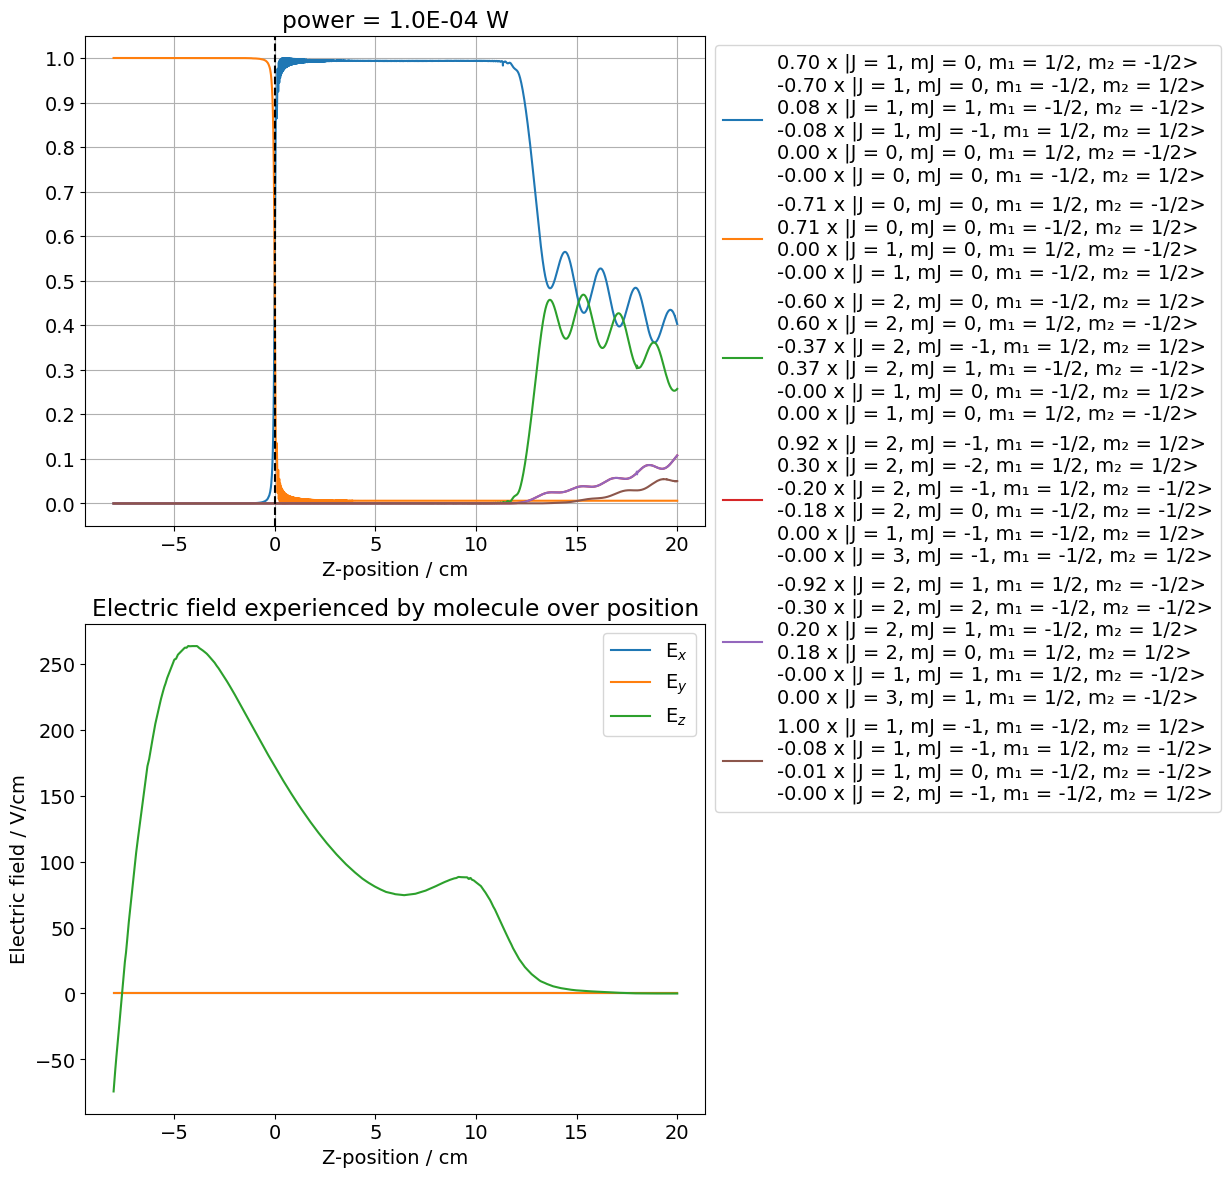

In [45]:
initial_state = result.initial_states[0]
large_prob_states = result.find_large_prob_states(initial_state, N=6)
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 14))
result.plot_state_probabilities(large_prob_states, initial_state, ax=ax, position=True)
ax.set_yticks(np.arange(0, 1.01, 0.1))
ax.legend(fontsize=14, bbox_to_anchor=(1.0, 1))
ax.axvline(x=R0[2] * 1e2, ls="--", c="k")
ax.set_title(f"power = {mf01.intensity.power:.1E} W")
ax.grid()

_ = electric_field.plot(trajectory, position=True, ax=ax2)


In [46]:
QN = [
    vector_to_state(result.V_ini[:, i], result.hamiltonian.QN)
    for i in range(len(result.hamiltonian.QN))
]

idx_J0_singlet = find_max_overlap_idx(
    J0_singlet.state_vector(result.hamiltonian.QN), result.V_ini
)
idx_J0_triplet_m = find_max_overlap_idx(
    J0_triplet_m.state_vector(result.hamiltonian.QN), result.V_ini
)
idx_J0_triplet_0 = find_max_overlap_idx(
    J0_triplet_0.state_vector(result.hamiltonian.QN), result.V_ini
)
idx_J0_triplet_p = find_max_overlap_idx(
    J0_triplet_p.state_vector(result.hamiltonian.QN), result.V_ini
)
idx_J1_singlet = find_max_overlap_idx(
    J1_singlet.state_vector(result.hamiltonian.QN), result.V_ini
)
idx_J1_triplet_m = find_max_overlap_idx(
    J1_triplet_m.state_vector(result.hamiltonian.QN), result.V_ini
)
idx_J1_triplet_0 = find_max_overlap_idx(
    J1_triplet_0.state_vector(result.hamiltonian.QN), result.V_ini
)
idx_J1_triplet_p = find_max_overlap_idx(
    J1_triplet_p.state_vector(result.hamiltonian.QN), result.V_ini
)

idx_J2_singlet = find_max_overlap_idx(
    J2_singlet.state_vector(result.hamiltonian.QN), result.V_ini
)
idx_J2_triplet_m = find_max_overlap_idx(
    J2_triplet_m.state_vector(result.hamiltonian.QN), result.V_ini
)
idx_J2_triplet_0 = find_max_overlap_idx(
    J2_triplet_0.state_vector(result.hamiltonian.QN), result.V_ini
)
idx_J2_triplet_p = find_max_overlap_idx(
    J2_triplet_p.state_vector(result.hamiltonian.QN), result.V_ini
)

# Scan RC Frequency
## Linear Polarization

In [87]:
# Define states
state1 = J0_triplet_0
state2 = J1_triplet_0

# Center position
R0 = np.array((0.00, 0, -0.0))

#### Polarization:
# Define polarization components
p_x = np.array([1, 0, 0])
p_y = np.array([0, 1, 0])
p_z = np.array([0, 0, 1])

# Define a function that gives the main component of the polarization as a function of position
p_main = p_z
P_R = lambda R: p_main / np.sqrt(np.sum(p_main**2))

# Define k-vector
k = np.array((1, 0, 0))
pol = Polarization(P_R, k, f_long=1)

#### Frequency
# Calculate the microwave frequency between specified states at a specific point
detuning_1 = 0e6
muW_freq_1 = (
    calculate_transition_frequency(state1, state2, hamiltonian.H_R(R0), hamiltonian.QN)
    + detuning_1
)

#### Intensity profile:
# Define a Gaussian intensity profile
# intensity = MeasuredBeam(power = 1e-3, sigma = 1*25.4e-3/(2*np.sqrt(2*np.log(2))), R0 = R0, k = k, freq = muW_freq)
intensity = GaussianBeam(
    power=0.5e-3,
    sigma=1 * 25.4e-3 / (2 * np.sqrt(2 * np.log(2))),
    R0=R0,
    k=k,
    freq=muW_freq_1,
)

#### Define MicrowaveField
mf01 = MicrowaveField(0, 1, intensity, pol, muW_freq_1, hamiltonian.QN)

In [88]:
def run_simulation(
    power_spa1: float,
    freq_spa1: float,
    rc_bg_fraction: float,
    freq_rc_bg: float,
    v_forward: float,
    initial_states: list[UncoupledState],
    indices_track=npt.NDArray[np.int64],
    N_steps=10_000,
) -> tuple[float, float, float, npt.NDArray[np.float64]]:
    """
    Runs the simulation for one value of power and finds the probability of ending up in the target state.
    """

    mf01.set_frequency(freq_spa1)
    mf12_rc_bg.set_frequency(freq_rc_bg)

    # set powers & intensities
    mf01.set_power(power_spa1)
    mf12_rc_bg.intensity.intensity = mf01.intensity.I_R(R0) * rc_bg_fraction

    # Run the simulator
    microwave_fields = [mf01, mf12_rc_bg]

    # # trajectories
    trajectory.Vini[-1] = v_forward

    simulator = Simulator(
        trajectory,
        electric_field,
        magnetic_field,
        initial_states,
        hamiltonian,
        microwave_fields,
    )

    result = simulator.run(N_steps=N_steps)
    probs = result.probabilities[-1, :, indices_track].copy()

    return (power_spa1, freq_spa1, rc_bg_fraction, freq_rc_bg, v_forward, probs)

In [89]:
indices_track = np.s_[0 : np.sum(utils.population.J_levels(np.array([0, 1, 2])))]

In [90]:
detunings = np.linspace(-15e6, 15e6, 31)
bg_fractions = np.logspace(0, np.log10(50), 11)

res = []
for bg_frac in tqdm.tqdm(bg_fractions):
    res.append(
        Parallel(n_jobs=nr_cores, verbose=0)(
            delayed(run_simulation)(
                power_spa1=1e-4,
                freq_spa1=muW_freq_1,
                rc_bg_fraction=bg_frac,
                freq_rc_bg=muW_rc_freq + detuning,
                v_forward=184.0,
                initial_states=initial_states_approx,
                indices_track=indices_track,
            )
            for detuning in detunings
        )
    )

100%|██████████| 11/11 [09:25<00:00, 51.39s/it]


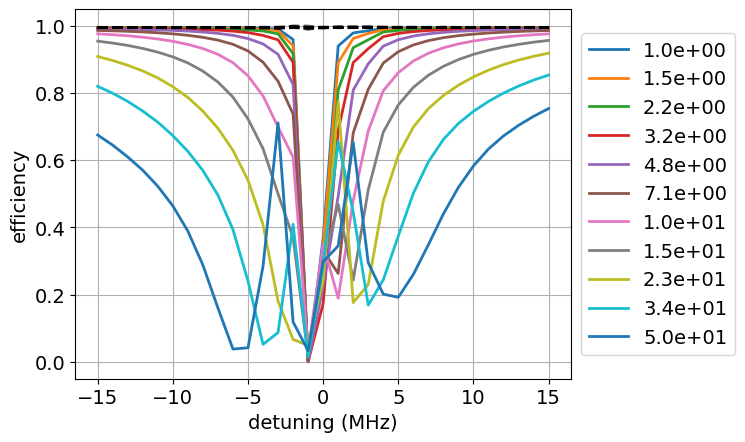

In [100]:
data = np.array([[r[-1] for r in re] for re in res])
labels = [f"{bg_frac:.1e}" for bg_frac in bg_fractions]

fig, ax = plt.subplots()

ax.plot(detunings / 1e6, data[:, :, 2, idx_J1_triplet_0].T, lw=2, label=labels)
ax.plot(
    detunings / 1e6,
    1 - data[:, :, 2, idx_J0_triplet_0].T,
    lw=2,
    color="k",
    ls="--",
    alpha=0.5,
)

ax.set_xlabel("detuning (MHz)")
ax.set_ylabel("efficiency")

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

ax.grid()

### Look where population is going

In [112]:
threshold = 21e-2
idx_fraction = 5

print(f"fraction: {bg_fractions[idx_fraction]}")

indices = np.unique(np.where(data[idx_fraction, :, 2, :] > threshold)[-1])
print(indices)
[QN[i].transform_to_coupled().largest for i in indices]

fraction: 7.071067811865475
[12 13 14 33 34 35]


[|X, J = 1, F₁ = 3/2, F = 2, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>,
 |X, J = 1, F₁ = 3/2, F = 2, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>,
 |X, J = 1, F₁ = 3/2, F = 2, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>,
 |X, J = 2, F₁ = 5/2, F = 3, mF = 1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 5/2, F = 3, mF = -1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 5/2, F = 3, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>]

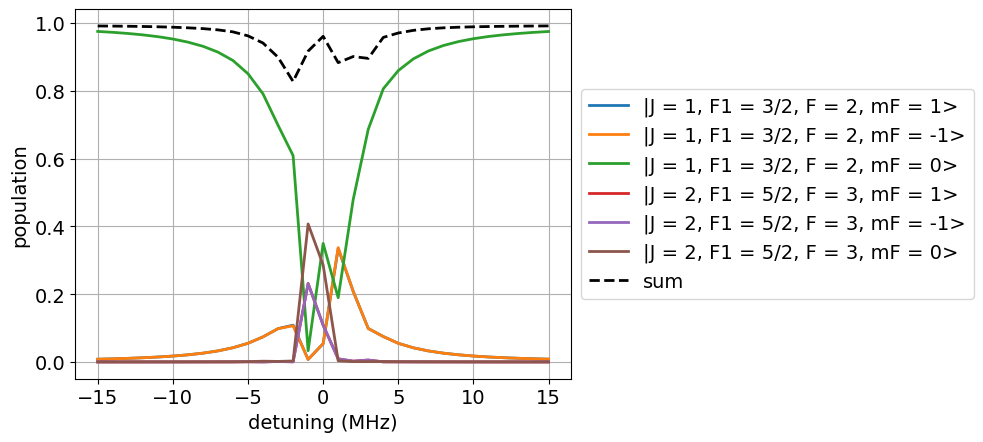

In [113]:
labels = [
    QN[i].transform_to_coupled().largest.state_string_custom(["J", "F1", "F", "mF"])
    for i in indices
]
fig, ax = plt.subplots()

ax.plot(detunings / 1e6, data[6, :, 2, indices].T, lw=2, label=labels)
ax.plot(
    detunings / 1e6,
    data[6, :, 2, indices].sum(axis=0),
    lw=2,
    ls="--",
    color="k",
    label="sum",
)

ax.set_xlabel("detuning (MHz)")
ax.set_ylabel("population")

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.grid()

# Scan Velocity and RC frequency

In [83]:
bg_fraction = 5
detunings = np.linspace(-15e6, 15e6, 31)
velocities = np.linspace(-32, 32, 9) + 184

res = []
for velocity in tqdm.tqdm(velocities):
    res.append(
        Parallel(n_jobs=nr_cores, verbose=0)(
            delayed(run_simulation)(
                power_spa1=1e-4,
                freq_spa1=muW_freq_1,
                rc_bg_fraction=bg_fraction,
                freq_rc_bg=muW_rc_freq + detuning,
                v_forward=velocity,
                initial_states=initial_states_approx,
                indices_track=indices_track,
            )
            for detuning in detunings
        )
    )

100%|██████████| 9/9 [07:28<00:00, 49.82s/it]


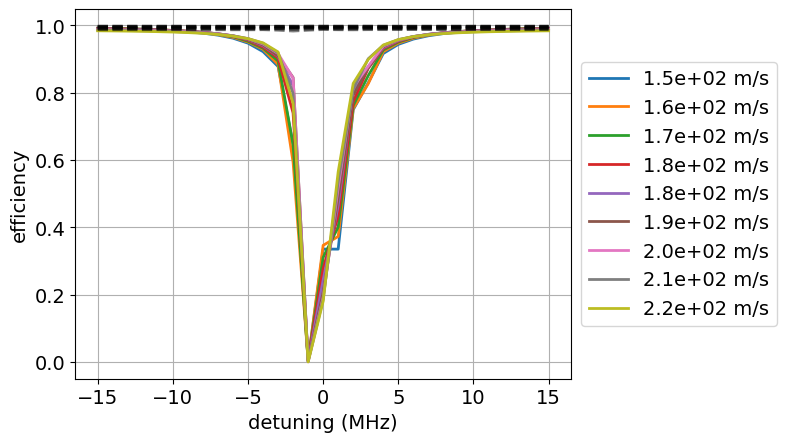

In [84]:
data = np.array([[r[-1] for r in re] for re in res])
labels = [f"{v:.1e} m/s" for v in velocities]

fig, ax = plt.subplots()

ax.plot(detunings / 1e6, data[:, :, 2, idx_J1_triplet_0].T, lw=2, label=labels)
ax.plot(
    detunings / 1e6,
    1 - data[:, :, 2, idx_J0_triplet_0].T,
    lw=2,
    color="k",
    ls="--",
    alpha=0.5,
)

ax.set_xlabel("detuning (MHz)")
ax.set_ylabel("efficiency")

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

ax.grid()

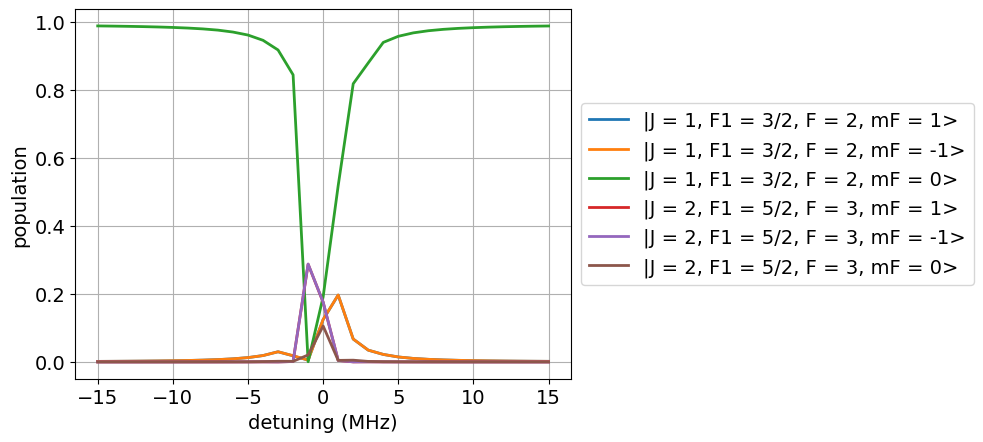

In [85]:
labels = [
    QN[i].transform_to_coupled().largest.state_string_custom(["J", "F1", "F", "mF"])
    for i in indices
]
fig, ax = plt.subplots()

ax.plot(detunings / 1e6, data[6, :, 2, indices].T, lw=2, label=labels)

ax.set_xlabel("detuning (MHz)")
ax.set_ylabel("population")

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.grid()